Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
import os
current_path = os.getcwd()
path_to_files = current_path + '/../sz_auxiliary_files/'

Esthetic definitions for the plots

In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [3]:
common_settings = {
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T10', #tinker et al 2010 @ M200m
                   'units for tSZ spectrum':'muK2'
}

battaglia_12_settings = {
    'mass function' : 'T08', #tinker et al 2008 @ M200m
    'sigma8': 0.8,
    'n_s' : 0.96,
    'Omega_b': 0.043,
    'Omega_cdm':0.25-0.043,
    'h':0.7,
    'units for tSZ spectrum':'muK2'
}

jch_settings = {
'mass function' : 'T10',
'omega_b' : 0.02240,
'omega_cdm' : 0.1146,
'h' : 0.697,
'tau_reio' : 0.08,
'A_s' : 2.43e-9,
'n_s' : 0.9646,
'k_pivot' : 0.002,
'N_ur' : 3.046,
'units for tSZ spectrum':'muK2',
'x_outSZ': 1.5 #1.5rvir is the truncation radius in jch's code
}


TCMB = 2.726 #Kelvin
TCMB_uK = 2.726e6 #micro-Kelvin


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV


# tsz function
def fsz(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz).astype(float)
    X = hplanck*nu/(kboltz*TCMB)
    resp = (X / np.tanh(X/2.0) - 4.0) * TCMB_uK #put explicitly into uK_CMB units,
    return resp


In [15]:
S =np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/run_scripts/tmp/class-sz_szpowerspectrum_0.6732.txt')

In [18]:
len(S[0,:])

67

# CMB with tSZ (class_sz) and kSZ (battaglia template)

In [10]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tCl,lCl,tSZ_1h,tSZ_2h',
        'modes':'s',
        'lensing': 'yes',
        'l_max_scalars':10000,
       'pressure profile': 'A10',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'B13',  # B13: Bhattacharya et al 2013  
       'ell_max' : 10000,
       'ell_min' : 2,
       'z_min': 1e-8,
       'z_max': 4.,
       'M_min':1e10, # all masses in Msun/h
       'M_max':5e15,
       'B': 1.7, #hydrostatic equilibrium bias (1-b)^-1
       'units for tSZ spectrum': 'muK2',
       'Frequency for y-distortion in GHz': 150.
        })
        
M.compute()
cl_sz = M.cl_sz()
# M.struct_cleanup()
# M.empty()

[]

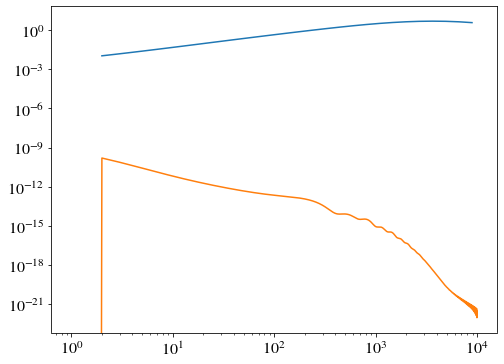

In [14]:
plt.plot(cl_sz['ell'],np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']))
plt.plot(M.lensed_cl()['ell'],M.lensed_cl()['tt'])
plt.loglog()

# compare with tSZ power spectrum measurments

In [4]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h,tSZ_2h',
       'pressure profile': 'A10',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'B13',  # B13: Bhattacharya et al 2013  
       'ell_max' : 10000,
       'ell_min' : 2,
       'z_min': 1e-8,
       'z_max': 4.,
       'M_min':1e10, # all masses in Msun/h
       'M_max':5e15,
       'B': 1.7, #hydrostatic equilibrium bias (1-b)^-1
       'units for tSZ spectrum': 'dimensionless'
        })
        
M.compute()
cl_sz = M.cl_sz()
M.struct_cleanup()
M.empty()

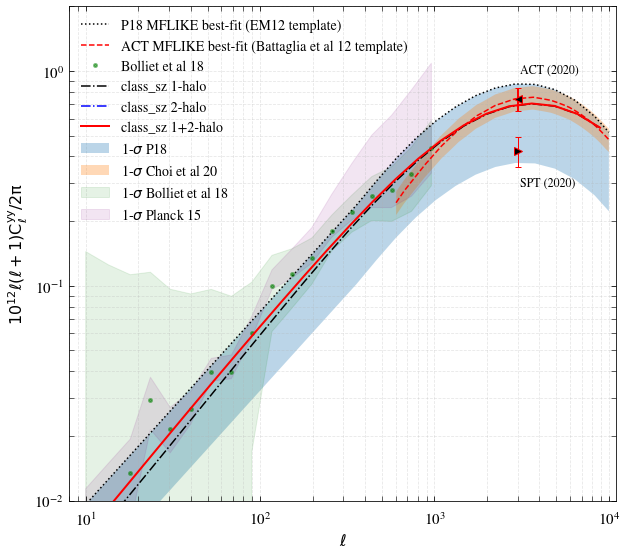

In [5]:
label_size = 15
title_size = 16
legend_size = 16
handle_length = 2
y_min = 1.e-2
y_max = 2

fig, ax1 = plt.subplots(1,1,figsize=(9,8))

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$',size=title_size)

ax.set_ylabel(r'$10^{12}\ell(\ell+1)\mathrm{C^{yy}_\ell/2\pi}$',size=title_size)


PSZ = np.loadtxt(path_to_files+'tsz_143_eps0.50.dat')
B12 = np.loadtxt(path_to_files+'cl_tsz_150_bat.dat')

pow_planck = interp1d(PSZ[:,0],PSZ[:,1])
tsz_planck = PSZ[:,1]
tsz_planck = 1e12*tsz_planck/fsz(143)/fsz(143)/pow_planck(3000)
A_sz_planck_mean = 5.
A_sz_planck_sigma = 2.
A_sz_planck_best_fit = 7.

plt.plot(PSZ[:,0],A_sz_planck_best_fit*tsz_planck,label='P18 MFLIKE best-fit (EM12 template)',c='k',ls=':')
plt.fill_between(PSZ[:,0],(A_sz_planck_mean-A_sz_planck_sigma)*tsz_planck,(A_sz_planck_mean+A_sz_planck_sigma)*tsz_planck,alpha=0.3,label = r'1-$\sigma$ P18')


tsz_B12 = B12[:,1]
pow_b12 = interp1d(B12[:,0],tsz_B12)
tsz_B12 = 1e12*tsz_B12/pow_b12(3000)/fsz(148)/fsz(148)
# tsz_B12 = 1e12*tsz_B12/pow_b12(3000)/(2.67e6)**2
pow_tsz_b12 = interp1d(B12[:,0],tsz_B12)
A_sz_act_mean = 5.29
A_sz_act_sigma = 0.66
A_sz_act_best_fit = 5.29
# A_sz_act_best_fit = 1.

plt.plot(B12[:,0][600:],A_sz_act_best_fit*tsz_B12[600:],label='ACT MFLIKE best-fit (Battaglia et al 12 template)',c='r',ls='--')
plt.fill_between(B12[:,0][600:],(A_sz_act_mean-A_sz_act_sigma)*tsz_B12[600:],(A_sz_act_mean+A_sz_act_sigma)*tsz_B12[600:],alpha=0.3,label = r'1-$\sigma$ Choi et al 20')


ACTCellnew = 5.29/(2.67)**2
ACTCellnewerr =	0.66/(2.67)**2

SPTCellnew = 3.42/(2.84)**2
SPTCellnewerr = 0.54/(2.84)**2

ax.errorbar([3000],[SPTCellnew],
            yerr=[SPTCellnewerr],capthick=1,capsize=3,elinewidth=1,\
             fmt='>',mfc='k',markersize=8,color = 'r')

ax.errorbar([3000],[ACTCellnew],
            yerr=[ACTCellnewerr],capthick=1,capsize=3,elinewidth=2,\
             fmt='<',mfc='k',markersize=8,color = 'r',zorder=100)
ax.text(3.1e3, 3.e-1, 'SPT (2020)', fontsize=12,rotation = 0,
verticalalignment='center',horizontalalignment='left')
ax.text(3.1e3, 1.01e0, 'ACT (2020)', fontsize=12,rotation = 0,
verticalalignment='center',horizontalalignment='left')



P = np.loadtxt(path_to_files+'planck_sz_1712_00788v1.txt')
# ax.errorbar(P[:,0][0:18],P[:,1][0:18],yerr = P[:,2][0:18],color='green',linestyle="None",alpha = .5,label = 'B18',marker='o',markersize=3,capsize=5,elinewidth=2,markeredgewidth=2)
ax.plot(P[:,0][0:18],P[:,1][0:18],color='green',linestyle="None",alpha = .5,label = 'Bolliet et al 18',marker='o',markersize=3,markeredgewidth=2)
ax.fill_between(P[:,0][0:18],P[:,1][0:18]-P[:,2][0:18],P[:,1][0:18]+P[:,2][0:18],
color='green',alpha=0.1,label=r'1-$\sigma$ Bolliet et al 18')

P = np.loadtxt(path_to_files+'Planck2015.txt')
# ax.errorbar(P[:,0][0:18],P[:,1][0:18],yerr = P[:,4][0:18],color='purple',linestyle="None",alpha = .2,label = 'P15',marker='o',markersize=3,capsize=5,elinewidth=2,markeredgewidth=2)
# ax.plot(P[:,0][0:18],P[:,1][0:18],color='purple',linestyle="None",alpha = .2,label = 'P15',marker='o',markersize=3,markeredgewidth=2)
ax.fill_between(P[:,0][0:18],P[:,1][0:18]-P[:,4][0:18],P[:,1][0:18]+P[:,4][0:18],
color='purple',alpha=0.1,label=r'1-$\sigma$ Planck 15')

plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['1h']),'k-.',label=r'class_sz 1-halo')
plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['2h']),'b-.',label=r'class_sz 2-halo')
plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']),c='r',lw=2,label=r'class_sz 1+2-halo')



ax.set_ylim(y_min,y_max)
ax.legend(loc=2,ncol=1,fontsize=14,frameon=False)
    
plt.xlim(8,1.1e4)
fig.tight_layout()

# tsz power spectrum - Arnaud et al 2010

In [16]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h,tSZ_2h',
       'pressure profile': 'A10',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'B13',  # B13: Bhattacharya et al 2013  
       'ell_max' : 10000,
       'ell_min' : 2,
       'z_min': 1e-8,
       'z_max': 4.,
       'M_min':1e10, # all masses in Msun/h
       'M_max':5e15,
       'B': 1.53, #hydrostatic equilibrium bias (1-b)^-1
        })
        
M.compute()
cl_sz = M.cl_sz()
M.struct_cleanup()
M.empty()

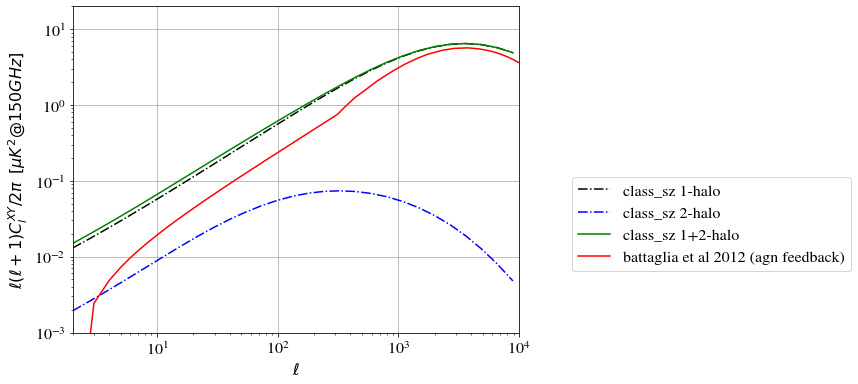

In [17]:
#
#################
#
# start plotting
#
#################
#
plt.xlim([2,10000])
plt.ylim([1.e-3,2e1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\mu K^2 @ 150GHz]$")
plt.grid()
#

plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['1h']),'k-.',label=r'class_sz 1-halo')
plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['2h']),'b-.',label=r'class_sz 2-halo')
plt.loglog(np.asarray(cl_sz['ell']),np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']),c='green',label=r'class_sz 1+2-halo')


path_to_b12_tp = current_path + '/../sz_auxiliary_files/cl_tsz_150_bat.dat'
l_b12, cl_b12 = np.loadtxt(path_to_b12_tp,unpack=True)
plt.loglog(l_b12,cl_b12,c='r',label='battaglia et al 2012 (agn feedback)')




plt.legend(loc=2,bbox_to_anchor=(1.1, 0.5))

loop over M_min:

In [9]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h,tSZ_2h',
       'pressure profile': 'A10',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'B13',  # B13: Bhattacharya et al 2013  
       'ell_max' : 10000,
       'ell_min' : 2,
       'z_min': 1e-8,
       'z_max': 4.,
       'M_min':1e10, # all masses in Msun/h
       'M_max':5e15,
       'B': 1.53, #hydrostatic equilibrium bias (1-b)^-1
       'hm_consistency':0 #deactivate counter terms since we want to cut the mass integral at low m
        })
# loop over M_min:
M_min_arr = np.geomspace(1e13,1e15,15)
cl_tot_arr = []
for mm in M_min_arr:
    M.set({'M_min':mm})
    M.compute()
    cl_sz = M.cl_sz()
    cl_tot_arr.append(np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']))
    ells = np.asarray(cl_sz['ell'])
M.struct_cleanup()
M.empty()   
    
    

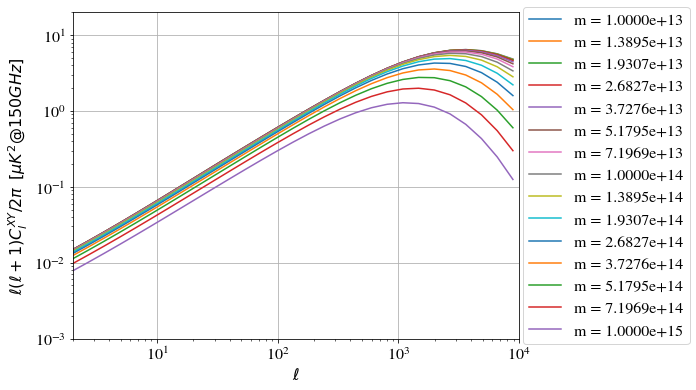

In [10]:
#
#################
#
# start plotting
#
#################
#
plt.xlim([2,10000])
plt.ylim([1.e-3,2e1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\mu K^2 @ 150GHz]$")
plt.grid()
#
for (i,mm) in enumerate(M_min_arr):
    plt.loglog(ells,cl_tot_arr[i],label=r'm = %.4e'%mm)

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# tsz power spectrum - Battaglia et al 2012

In [11]:
M = Class()
# M.set(battaglia_12_settings)
M.set(jch_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h,tSZ_2h',
       'pressure profile': 'B12',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'D08',  # D08: Duffy et al 2008, as in https://arxiv.org/pdf/1109.3711.pdf
       'ell_max' : 10000,
       'ell_min' : 2,
       'z_min': 0.005,
       'z_max': 10.,
       'M_min':2e5, # all masses in Msun/h
       'M_max':5e15,
       'z_max_pk' : 10.,
        'hm_consistency':0,
        'T10_alpha_fixed':1,
        'n_ell_pressure_profile' : 70,
        'n_m_pressure_profile' : 70,
        'n_z_pressure_profile' : 300
        })
        
M.compute()
cl_sz_jch = M.cl_sz()
M.struct_cleanup()
M.empty()

In [12]:
M = Class()
# M.set(battaglia_12_settings)
M.set(battaglia_12_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h,tSZ_2h',
       'pressure profile': 'B12',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'concentration parameter': 'D08',  # D08: Duffy et al 2008, as in https://arxiv.org/pdf/1109.3711.pdf
       'ell_max' : 20000,
       'ell_min' : 2,
       'z_min': 0.07,
       'z_max': 5.,
       'M_min':4e10, # all masses in Msun/h
       'M_max':5e15,
       'z_max_pk' : 10.,
        'hm_consistency':0,
        'n_ell_pressure_profile' : 70,
        'n_m_pressure_profile' : 70,
        'n_z_pressure_profile' : 70,

        'x_outSZ':150.
        })
        
M.compute()
cl_sz_b12 = M.cl_sz()
M.struct_cleanup()
M.empty()

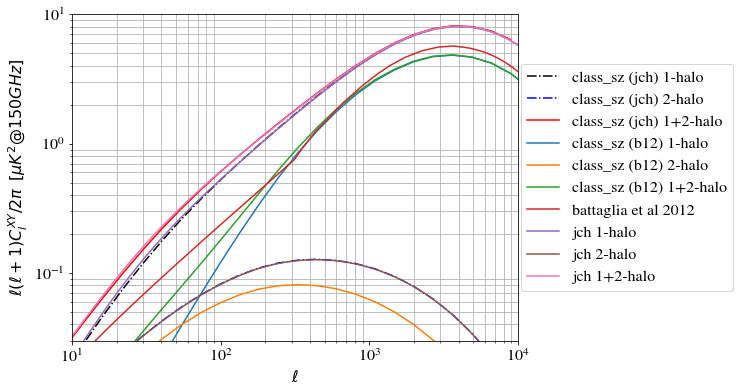

In [13]:
#
#################
#
# start plotting
#
#################
#

plt.xlim([10,10000])
plt.ylim([3.e-2,1e1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\mu K^2 @ 150GHz]$")
plt.grid()
#

plt.loglog(np.asarray(cl_sz_jch['ell']),np.asarray(cl_sz_jch['1h']),'k-.',label=r'class_sz (jch) 1-halo')
plt.loglog(np.asarray(cl_sz_jch['ell']),np.asarray(cl_sz_jch['2h']),'b-.',label=r'class_sz (jch) 2-halo')
plt.loglog(np.asarray(cl_sz_jch['ell']),np.asarray(cl_sz_jch['1h'])+np.asarray(cl_sz_jch['2h']),'r-',label=r'class_sz (jch) 1+2-halo')


plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['1h']),label=r'class_sz (b12) 1-halo')
plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['2h']),label=r'class_sz (b12) 2-halo')
plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['1h'])+np.asarray(cl_sz_b12['2h']),label=r'class_sz (b12) 1+2-halo')



path_to_b12_tp = current_path + '/../sz_auxiliary_files/cl_tsz_150_bat.dat'
l_b12, cl_b12 = np.loadtxt(path_to_b12_tp,unpack=True)
plt.loglog(l_b12,cl_b12,label='battaglia et al 2012')

LC = np.loadtxt(current_path + '/../sz_auxiliary_files/chill_cltsz_data_B12.txt')
# LC = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/chill_cltsz_data_A10.txt')
multipoles_ref = LC[:,0]
cl_1h_ref = 1.e12*LC[:,9]*LC[:,0]*(LC[:,0]+1.)/2./np.pi
cl_2h_ref = 1.e12*LC[:,10]*LC[:,0]*(LC[:,0]+1.)/2./np.pi

nu_y_dist_GHz = 150.
frequency_in_Hz = nu_y_dist_GHz*1e9
T_cmb = 2.7255
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
Tcmb_gNU = T_cmb*((_h_P_*frequency_in_Hz/(_k_B_*T_cmb))*(1./np.tanh((_h_P_*frequency_in_Hz/(_k_B_*T_cmb))/2.))-4.)


plt.loglog(multipoles_ref,Tcmb_gNU**2.*(cl_1h_ref),label='jch 1-halo')
plt.loglog(multipoles_ref,Tcmb_gNU**2.*(cl_2h_ref),label='jch 2-halo')
plt.loglog(multipoles_ref,Tcmb_gNU**2.*(cl_1h_ref+cl_2h_ref),label='jch 1+2-halo')


plt.grid(which='both')
plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))

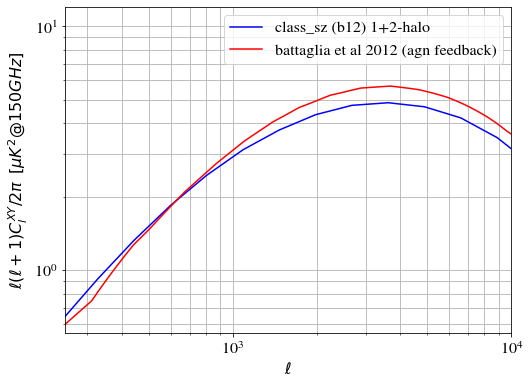

In [14]:
#
#################
#
# start plotting
#
#################
#

plt.xlim([250,10000])
plt.ylim([5.5e-1,1.2e1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\mu K^2 @ 150GHz]$")
plt.grid()
#



# plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['1h']),label=r'class_sz (b12) 1-halo')
# plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['2h']),label=r'class_sz (b12) 2-halo')
plt.loglog(np.asarray(cl_sz_b12['ell']),np.asarray(cl_sz_b12['1h'])+np.asarray(cl_sz_b12['2h']),c='b',label=r'class_sz (b12) 1+2-halo')

plt.grid()

path_to_b12_tp = current_path + '/../sz_auxiliary_files/cl_tsz_bat_150.txt'
l_b12, cl_b12 = np.loadtxt(path_to_b12_tp,unpack=True)
plt.loglog(l_b12,cl_b12,c='r',label='battaglia et al 2012 (agn feedback)')





plt.legend(loc=1)
plt.grid(which='both')